This Notebook contains all figures generated for the Wastewater-based epidemiology project - Radx-rad
Jiang lab NLM-NIH
Rafaela Salgado Fontenele - research fellow

Overview figures
input - WWBE_metadata.tsv

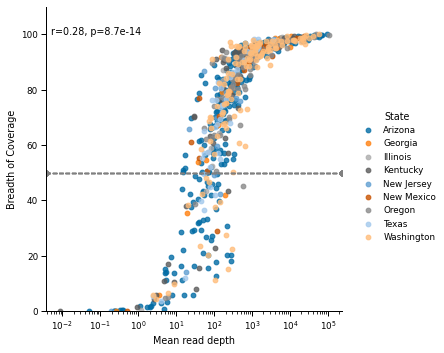

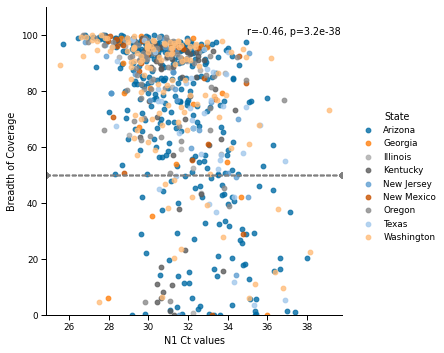

In [15]:
#plot Coverage vs Ct values

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import scipy.stats as sp


plt.style.use('tableau-colorblind10')
sns.set_context("paper")
data = pd.read_table("WWBE_metadata.tsv", header=0, sep="\t")
data = data[data["Ct_N1"] != "Undetermined"]
data["Ct_N1"] = data["Ct_N1"].astype(float)
data = data.sort_values(by=["State"])


ax2 = sns.lmplot(data=data, x="Ct_N1" , y="Breadth_galaxy", hue="State", fit_reg=False, truncate=True, facet_kws={"legend_out":True})
ax1 = sns.lmplot(data=data, x="Mean_galaxy" , y="Breadth_galaxy", hue="State", fit_reg=False, truncate=True, facet_kws={"legend_out":True})
    

# Improve the legend 

ax2 = (ax2.set_axis_labels("N1 Ct values", "Breadth of Coverage")
      .set(ylim=(0,110))) 
plt.xscale("log")
ax1 = (ax1.set_axis_labels("Mean read depth", "Breadth of Coverage")
        .set(ylim=(0,110)))

# Get Persons correlation and add line to 50% coverage threshhold 
r, p = sp.stats.pearsonr(data['Mean_galaxy'], data['Breadth_galaxy'])
a, b = sp.stats.pearsonr(data['Ct_N1'], data['Breadth_galaxy'])
fc1 = ax1.axes[0,0]
fc2 = ax2.axes[0,0]
fc1.text(.005, 100, 'r={:.2f}, p={:.2g}'.format(r, p))
fc2.text(35, 100, 'r={:.2f}, p={:.2g}'.format(a, b))
ax1.refline(y=50)
ax2.refline(y=50)

ax1.savefig("breadth_mean_fig.png", bbox_inches='tight')
ax1.savefig("breadth_mean_fig.pdf", bbox_inches='tight')
ax2.savefig("breadth_ct_fig.png", bbox_inches='tight')
ax2.savefig("breadth_ct_fig.pdf", bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


584
223


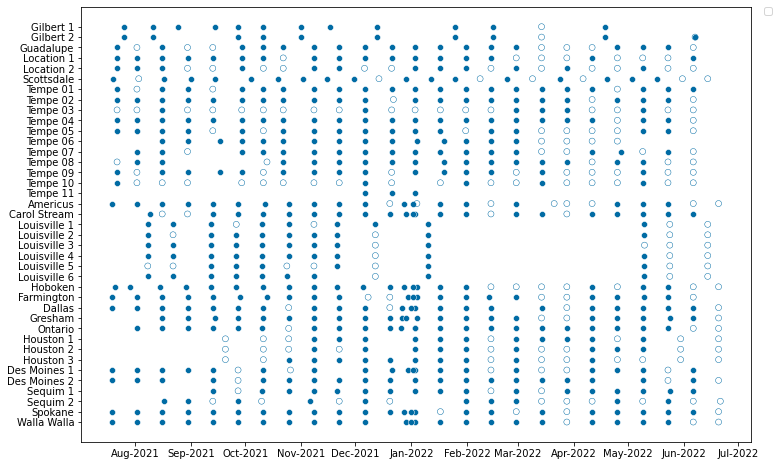

In [1]:

#Overview figure

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib as mlp
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(12,8))
meta = pd.read_csv("WWBE_metadata_edited.tsv", sep="\t")
meta["Sampler_Start_Date"] = pd.to_datetime(meta["Sampler_Start_Date"])
meta = meta.sort_values(by=["State", "City", "Location"])
meta_grouped = meta.groupby("Sample")
good= meta_grouped.get_group("Wastewater")
bad = meta_grouped.get_group("BS")


ax = sns.scatterplot(x="Sampler_Start_Date", y="Location",  data=good, color='#006ba4')
ax = sns.scatterplot(x="Sampler_Start_Date", y="Location", data=bad, facecolor="none", edgecolor='#006ba4')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_ylabel("")
ax.set_xlabel("")
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.savefig("overview_figure.pdf", bbox_inches='tight')
plt.show()

Figure PCoA
input: Cov-dist result 

In [ ]:
# Plotting PCoA plots - either all or by State (group option)

def dist2PcoA(dist):
    from skbio.stats.ordination import pcoa
    ordination_result = pcoa(dist)
    return ordination_result

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.distance import DistanceMatrix
from argparse import ArgumentParser
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib import patches

parser = ArgumentParser(description='Generate PcoA plots for WWBE')
parser.add_argument('-f', '--file', help='path to distance file', required=True, dest='file')
parser.add_argument('-o', '--output', help='name of the ouput file (.png)', dest='output')
parser.add_argument('-m', '--path', help='path metadata file', dest='meta')
parser.add_argument('-g', '--group', help='group to plot', dest='group', required= True)
args = parser.parse_args()

meta = pd.read_csv(args.meta,sep="\t",index_col=0,header=None,names=["Group", "State", "Dates"])
#meta['Lineages']=meta['Lineages'].astype("category")
meta['Group']=meta['Group'].astype("category")
meta['State']=meta['State'].astype("category")
#meta['Dates']=meta['Dates'].astype("category")


dist = DistanceMatrix.read(args.file)
dist_filter = dist.filter(meta.index, strict=False)
ordination_result = dist2PcoA(dist_filter)

df = pd.concat([ordination_result.samples,meta],axis=1)
PC1_p = str("{:.2f}".format((ordination_result.proportion_explained["PC1"]) * 100))
PC2_p = str("{:.2f}".format((ordination_result.proportion_explained["PC2"]) * 100))

df = df.set_index("Group")
df = df.sort_values(by=["Dates"])
df["Dates"] = pd.to_datetime(df["Dates"])
df["Date"] = df["Dates"].dt.strftime(date_format="%b - %y")
df['Date']=df['Date'].astype("category")
print(df)
plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(10,10))
delta = df.loc["Delta"]
my_color=delta["Date"].cat.codes

color_dict = dict({'Delta':'black', "Omicron":"black", "wastewater":"white"})
ax.scatter(x="PC1", y="PC2", marker="x", c="black", label="Delta", data=delta)
omicron = df.loc["Omicron"]
my_color=omicron["Date"].cat.codes
ax.scatter(x="PC1", y="PC2", marker=">", c="black", label="Omicron", data=omicron)
samples = df.loc["wastewater"]
samples = samples.sort_values(by=["State","Dates"])

if args.group == "all":

    legend=samples["Date"].unique().tolist()
    samples["Date"] = samples["Date"].cat.remove_unused_categories()
    samples["Date"]= samples["Date"].cat.reorder_categories(legend, ordered=True)
    my_color=samples["Date"].cat.codes
    scat_plot = ax.scatter(x="PC1", y="PC2", marker="o", c=my_color, label="Wastewater", cmap=plt.cm.get_cmap('tab20b', len(legend)), data=samples, lw=0, alpha=0.5)
    cb = plt.colorbar(scat_plot, pad=0.05, shrink=0.65)
    r = cb.vmax - cb.vmin
    cb.set_ticks([cb.vmin + r / len(legend) * (0.5 + i) for i in range(len(legend))])
    cb.set_ticklabels(legend)

if args.group != "all":
    legend=samples["Date"].unique().tolist()
    samples["Date"] = samples["Date"].cat.remove_unused_categories()
    samples["Date"]= samples["Date"].cat.reorder_categories(legend, ordered=True)
    my_color=samples["Date"].cat.codes
    state = args.group
    samples = samples.reset_index()
    samples = samples.set_index("State")
    group = samples.loc[state]
    legend=group["Date"].unique().to_list()
    group["Date"] = group["Date"].cat.remove_unused_categories()
    group["Date"]= group["Date"].cat.reorder_categories(legend, ordered=True)
    scat_plot = ax.scatter(x="PC1", y="PC2", marker="o", c=my_color, label="Wastewater", cmap=plt.cm.get_cmap('tab20b', len(legend)), data=samples, lw=0, alpha=0)
    my_color=group["Date"].cat.codes
    scat_plot = ax.scatter(x="PC1", y="PC2", marker="o", c=my_color, label=state, cmap=plt.cm.get_cmap('tab20b', len(legend)), data=group, lw=0, alpha=0.5)
    cb = plt.colorbar(scat_plot, pad=0.05, shrink=0.9)
    r = cb.vmax - cb.vmin
    cb.set_ticks([cb.vmin + r / len(legend) * (0.5 + i) for i in range(len(legend))])
    cb.set_ticklabels(legend)

plt.legend(loc='lower right', frameon=True, bbox_to_anchor=(-0.1, 0.1))
plt.gca().set_aspect("equal",adjustable="box")
ax.set_xlabel("PC1 " + "("+PC1_p+")")
ax.set_ylabel("PC2 " + "("+PC2_p+")")
plt.savefig(args.output+"/"+args.group+"_samples.png", bbox_inches='tight')
plt.savefig(args.output+"/"+args.group+"_samples.pdf", bbox_inches='tight')
plt.plot()
plt.close


Code for plotting derived SNVs
1. Step 1 obtains the raw data files 
input: 
    vcf result edited into a tsv file for each sample - {sample}_trimmed_union_snpEff_final_filtered.tsv
    WWBE_metadata.tsv
    child_parent_info_{date}_all.pkl
2. Generates heatmap with all VOCs but no depth information
input:
    child_parent_info_{date}_all.pkl
    lineagePaths_edited_clades_{date}.pkl
3. Obtains depth information and includes in the pivot to tables to plot heatmap
input:
    Samples depth file
    WWBE_metadata.tsv
    outputs from code 2
4. Adapted code for heatmap plotting that only plots major vocs (Omicron and Delta)
input:
    outputs from code 2 and 3

In [ ]:
# GET THE FILES WITH DERIVED SNVS REPRESENTED IN EACH SAMPLE

#!/usr/bin/env python
import pandas as pd
import pickle
import os

#get ww samples info
def sample_info(file):# add file name as argument in future
    if os.path.isfile("/gpfs/gsfs12/users/Irp-jiang/share/rafa_data/wwbe_variant_files/" + str(file) + "_trimmed_union_snpEff_final_filtered.tsv"):
        tsv = pd.read_csv("/gpfs/gsfs12/users/Irp-jiang/share/rafa_data/wwbe_variant_files/" + str(file) + "_trimmed_union_snpEff_final_filtered.tsv", sep="\t", dtype=object)
        sample_snvs = [mut for mut in tsv['Variant']]
    else:
        print("The file " + str(file) + " is not present.")
        sample_snvs=[]
        tsv = pd.DataFrame()
    return sample_snvs, tsv

# get derived snvs lineage info
def lineage_info():
    derived_snvs = pd.read_pickle(args.file)
    return derived_snvs

def supporting_snps(derived_snvs, sample_support, parent, lineages, sample_snvs, all_lin, file):
    if parent in derived_snvs.index:
        sliced = derived_snvs.loc[[parent], ["lineage","child", "snvs", "derived_snvs"]]
        for i, row in sliced.iterrows():
            derived_snvs_list = row["derived_snvs"]
            child_list = row["child"]
            lineage = row["lineage"]
            num_mutations=0
            unique_mutations=0
            total_num=0
            for info in derived_snvs_list:
                for key, item in info.items():
                    for mutation in sample_snvs:
                        if key == mutation:
                            num_mutations+=1
                            if mutation not in sample_support:
                                sample_support.append(mutation)
                            if ":" in mutation:
                                all_lin.append(lineage)
                                lineages[lineage]="insertion"
                            if len(item) == 1 and item[0] == lineage:
                                unique_mutations+=1                    
                total_num=len(derived_snvs_list)
            # add a paramenter input here to control frequency of snvs per lineage to be accepted
            if total_num != 0:
                all_snvs = num_mutations/total_num
                if unique_mutations == 0 and all_snvs == 1 or all_snvs >= 0.70:
                    lineages[lineage]=all_snvs
                    if lineage not in all_lin:
                        all_lin.append(lineage)
            supporting_snps(derived_snvs, sample_support, lineage, lineages, sample_snvs, all_lin, file)
    return sample_support, lineages, all_lin


def get_plot_info(result, tsv, file, date, location, state, city):
    df = pd.DataFrame()
    for mutation in result:
        for i, row in tsv.iterrows():
            if mutation == row["Variant"] and float(row["AF"]) >= 0.2:
                df = df.append({'Sample': file, 'Variant': mutation, 'Frequency': row["AF"], "Lineages": [], 'Date': date, 'Location': location, "State": state, "City":city}, ignore_index=True)
    return df

def get_data(sample_list, meta):
    parent="root" #will be root for all the lineages
    sample_support=[]
    lineages={}
    all_lin=[]
    result_snvs= pd.DataFrame()
    derived_snvs = lineage_info()
    derived_snvs.set_index("parent", inplace=True)
    df = pd.DataFrame()
    for file in sample_list:
        sample_snvs, tsv = sample_info(file)
        if tsv.empty: #if the file does not exist just skip it
            continue
        else:
            date = meta.loc[meta["Sample_name"] == file, "Sampler_Start_Date"].iloc[0]
            location = meta.loc[meta["Sample_name"] == file, "Location"].iloc[0]
            state = meta.loc[meta["Sample_name"] == file, "State"].iloc[0]
            city = meta.loc[meta["Sample_name"] == file, "City"].iloc[0]
            result, lineages_dic, all_lin = supporting_snps(derived_snvs, sample_support, parent, lineages, sample_snvs, all_lin, file)
            plot_info = get_plot_info(result, tsv, file, date, location, state, city)
            df = df.append(plot_info, ignore_index=True)
            snvs_not_supported = [snp for snp in sample_snvs if snp not in result]
            result_snvs = result_snvs.append({"Sample":file, "Supported_snvs": result, "Not_supported_snvs": snvs_not_supported}, ignore_index=True)
    derived_snvs.reset_index(inplace=True)
    derived_snvs.set_index("lineage", inplace=True)
    #this section removes lineages if the parent is not present in the dictionary
    to_drop=[]
    for lin in all_lin:
        parent=derived_snvs.loc[lin, "parent"]
        if parent not in all_lin and parent not in ["A","B","B.1.1.529"]:
            to_drop.append(lin)
    all_lin_updated = [lin for lin in all_lin if lin not in to_drop]
    lineages_dic_updated = {key:value for key,value in lineages_dic.items() if key not in to_drop}
    sliced = derived_snvs.loc[all_lin, "derived_snvs"]
    for idx, line in df.iterrows():
        for i, row in sliced.iteritems():
            for mut in row:
                for k,v in mut.items():
                    if k == line["Variant"]:
                        for lin in v:
                            if lin not in line["Lineages"] and lin in all_lin_updated:
                                line["Lineages"].append(lin)
    print(lineages_dic_updated)
    result_snvs.to_csv(args.outpath+"/report_supported_snvs.tsv", sep="\t", index=False)
    return result, df, lineages_dic_updated

def main():
    meta = pd.read_csv(args.meta, sep="\t")
    meta = meta.sort_values(by=["State", "City", "Sampler_Start_Date"])
    if args.group == "all":
        sample_list = [sample for sample in meta["Sample_name"]] 
        result_dic, to_plot, lineages = get_data(sample_list, meta)
        to_plot.to_csv(args.outpath+"/results.tsv", sep="\t", index=False)
    if args.group != "all":
        group_type = args.group
        meta_grouped = meta.groupby([group_type])
        for name, group in meta_grouped:
            sample_list = [sample for sample in group["Sample_name"]] # change to group for slicing
            result_dic, to_plot, lineages = get_data(sample_list, meta)
            group_name = name
            result_dic.to_csv(args.outpath+"/"+group_name+"_report_supported_snvs.tsv", sep="\t", index=False)
            to_plot.to_csv(args.outpath+"/"+group_name+"_results.tsv", sep="\t", index=False)
           


if __name__ == '__main__':

    from argparse import ArgumentParser

    parser = ArgumentParser(description='Generate Heatmaps with derived SNVs info from SARS-CoV-2 and wastewater samples')
    parser.add_argument('-f', '--file',help='updated file of derived snvs', required=True,dest='file',metavar='')
    parser.add_argument('-m', '--meta',help='file containing metadata info', required=True,dest='meta',metavar='')
    parser.add_argument('-o', '--outpath',help='output folder name', required=True,dest='outpath',metavar='')
    parser.add_argument('-g', '--group',help='grouping of samples', required=False, default="all", dest='group',metavar='')
    args = parser.parse_args()

    if not os.path.exists(args.outpath):
        os.mkdir(args.outpath)
    else:
        print('Outpath already exists and will be overwritten!')
    main()






In [ ]:
#Heatmap plot with all VOCs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib as mpl
from argparse import ArgumentParser


def get_cmap_grey():
    gray_cmap = plt.cm.gray
    cmaplist = [
        (.98, .98, .98, 1), # not found => white
        *[gray_cmap(int(i)) for i in np.linspace(gray_cmap.N-50, 50, 20)],
        (0,0,0,1)  # found in all => black
    ]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))
    return cmap

deltas=["B.1.617.2", "B.1.617.2"]
betas=["B.1.351", "B.1.351."]
gammas=["P.1", "P.1."]
alphas=["B.1.1.7", "Q."]
omicrons=["B.1.1.529", "B.1.1.529"]
mu=["B.1.621", "B.1.621."] #"BB.2"
kappa=["B.1.617.1", "B.1.617.1"]
eta=["B.1.525", "B.1.525."]
#epsilon=["B.1.427", "B.1.429"]
iota=["B.1.526", "B.1.526."]
lamda=["C.37", "C.37."]


# clades =  {"Alpha":"20I", "Beta":"20H", "Delta":"21A,21I,21J", "Eta":"21D", "Gamma":"20J", \
#      "Iota":"21F", "Kappa":"21B", "Lambda":"21G", "Mu":"21H", "Omicron":"21K,21L"}
clades =  {"Alpha":1, "Beta":2, "Delta":"21A,21I,21J", "Eta":6, "Gamma":7, \
     "Iota":8, "Kappa":9, "Lambda":10, "Mu":11, "Omicron":"21K,21L"}

def get_lineage_list(base, alias, file):
    lin_list=[]
    for i,row in file.iterrows():
        if i == base or i.startswith(alias):
            lin_list.append(i)
    return lin_list


def annotate(voc, lin_list, variants_to_use, file):
    new_df = pd.DataFrame()
    for i,row in file.iterrows():
        if i in lin_list:
            for var in row["derived_snvs"]:
                new_df = new_df.append({"VOC": voc, "Variants": list(var.keys())[0], "Clade": clades[voc]},ignore_index=True)
    new_df.drop_duplicates(inplace=True)
    return new_df

def annotate_delta(voc, lin_list, variants_to_use, file, clade):
    delta_21J= clade.loc["21J (Delta)", "SNVs"]
    delta_21I= clade.loc["21I (Delta)", "SNVs"]
    delta_21A= clade.loc["B.1.617.2", "SNVs"]
    base = clade.loc["B.1", "SNVs"]
    d_21J = [lin for lin in delta_21J if lin not in delta_21A]
    d_21I = [lin for lin in delta_21I if lin not in delta_21A]
    d_21A = [lin for lin in delta_21A if lin not in base]
    new_df = pd.DataFrame()
    for var in d_21A:
        new_df = new_df.append({"VOC": voc, "Variants": var, "Clade":3}, ignore_index=True)
    for var in d_21J:
        new_df = new_df.append({"VOC": voc, "Variants": var, "Clade":4}, ignore_index=True)
    for var in d_21I:
        new_df = new_df.append({"VOC": voc, "Variants": var, "Clade":5}, ignore_index=True)
    new_df.drop_duplicates(inplace=True)
    return new_df

def annotate_omicron(voc, lin_list, variants_to_use, file, clade):
    omicron_21K_clade= clade.loc["BA.1", "SNVs"]
    omicron_21L_clade= clade.loc["BA.2", "SNVs"]
    omicron_base_clade = clade.loc["B.1.1.529", "SNVs"]
    omicron_21M= file.loc["B.1.1.529", "derived_snvs"]
    omicron_21K= file.loc["BA.1", "derived_snvs"]
    omicron_21L= file.loc["BA.2", "derived_snvs"]
    omicron_list = [key for dic in omicron_21M for key, v in dic.items()]
    omicron_list_21K = [key for dic in omicron_21K for key, v in dic.items()]
    omicron_list_21L = [key for dic in omicron_21L for key, v in dic.items()]
    dev_21K = [lin for lin in omicron_21K_clade if lin not in omicron_base_clade]
    dev_21L = [lin for lin in omicron_21L_clade if lin not in omicron_base_clade]
    d_21K = dev_21K + omicron_list
    d_21L = dev_21L + omicron_list
    final_21K = list(set(d_21K + omicron_list_21K))
    final_21L = list(set(d_21L + omicron_list_21L))
    new_df = pd.DataFrame()
    for var in final_21K:
        new_df = new_df.append({"VOC": voc, "Variants": var, "Clade":12}, ignore_index=True)
    for var in final_21L:
        new_df = new_df.append({"VOC": voc, "Variants": var, "Clade":13}, ignore_index=True)
    new_df.drop_duplicates(inplace=True)
    return new_df


def complex_plot():
    to_plot = pd.read_csv(args.outpath+"results.tsv", sep="\t")
    file = pd.read_pickle("child_parent_info_"+ args.dateg + "_all.pkl")
    file = file.set_index("lineage")
    clade= pd.read_pickle("lineagePaths_edited_clades_"+ args.dateu + ".pkl")
    clade = clade.set_index("Lineage")
    #setting the info from samples
    idx=[]
    for i,row in to_plot.iterrows():
        if not row["Lineages"]:
            idx.append(i)
    to_plot.drop(idx, inplace = True)
    to_plot = to_plot.set_index("Variant")
    variants_to_use = to_plot.index.to_list()
    #match sample info to the vocs
    df_all = pd.DataFrame()
    vocs_list = [{"Alpha":alphas}, {"Beta":betas}, {"Delta":deltas}, {"Eta":eta}, {"Gamma":gammas}, \
        {"Iota":iota}, {"Kappa":kappa}, {"Lambda":lamda}, {"Mu":mu}, {"Omicron":omicrons}]
    for voc in vocs_list:
        for key, value in voc.items():
            if key == "Delta":
                lin_list = get_lineage_list(value[0], value[1], file)
                df = annotate_delta(key, lin_list, variants_to_use, file, clade)
                df_all = df_all.append(df, ignore_index=True)
            if key == "Omicron":
                lin_list = get_lineage_list(value[0], value[1], file)
                df= annotate_omicron(key, lin_list, variants_to_use, file, clade)
                df_all= df_all.append(df, ignore_index=True)
            elif key not in ["Delta", "Omicron"]:
                lin_list = get_lineage_list(value[0], value[1], file)
                df = annotate(key, lin_list, variants_to_use, file)
                df_all= df_all.append(df, ignore_index=True)
    
    df_all['count'] = df_all.groupby('Variants')['Variants'].transform('count')
    df_all=df_all.set_index("Variants")
    

    unique = df_all.groupby("count").get_group(1)
    shared = df_all.drop(unique.index.to_list())

    # checking for shared between clades of the same VOC
    new_pivot_shared = pd.pivot_table(data=shared, columns=["VOC"], index=["Variants"], values=["Clade"], aggfunc="first")
    new_pivot_shared.columns = new_pivot_shared.columns.get_level_values(1)
    omicron_cl = new_pivot_shared[new_pivot_shared.Omicron.notna() & (new_pivot_shared.isnull().sum(axis=1) == len(new_pivot_shared.columns) - 1)]
    omicron_index = omicron_cl.index.tolist()
    new_pivot_shared = new_pivot_shared.drop(omicron_index)
    for item in omicron_index:
        unique.loc[item] = ["Omicron", 14, 1]
    delta_cl = new_pivot_shared[new_pivot_shared.Delta.notna() & (new_pivot_shared.isnull().sum(axis=1) == len(new_pivot_shared.columns) - 1)]
    delta_index = delta_cl.index.tolist()
    new_pivot_shared = new_pivot_shared.drop(delta_index)
    for item in delta_index:
        unique.loc[item] = ["Delta", 14, 1]
    vocs = [k for d in vocs_list for k in d.keys()]
    for lin in vocs:
        if lin not in new_pivot_shared.columns:
            new_pivot_shared[lin] = np.nan

    new_pivot_unique = pd.pivot_table(data=unique, columns=["VOC"], index=["Variants"], values=["Clade"], aggfunc="first")
    new_pivot_unique.columns = new_pivot_unique.columns.get_level_values(1)
    for lin in vocs:
        if lin not in new_pivot_unique.columns:
            new_pivot_unique[lin] = np.nan
    new_pivot_shared = new_pivot_shared.sort_values(by=list(new_pivot_shared.columns), axis=0)
    new_pivot_unique = new_pivot_unique.sort_values(by=list(new_pivot_unique.columns), axis=0)
    new_pivot_unique.to_csv(args.outpath+"vocs_unique.tsv", sep="\t")
    new_pivot_shared.to_csv(args.outpath+"vocs_shared.tsv", sep="\t")
    sns.set()
    fig, ((ax1, ax3), (ax2, ax4), (cbar_ax, cbar_ax2)) = plt.subplots(3,2, figsize=(60,60),\
         gridspec_kw={'height_ratios':[len(new_pivot_unique),len(new_pivot_shared),10], "width_ratios":[0.1,1]})


    colors= ["#C36C69", "#ED706B", "#F4B6B5", "#7DBF70", "#BDFC8F", "#74A16C", "#9A6A9F", "#CAB0CD", \
    "#B8FCD4", "#66679F", "#F6C5FB", "#BF6C97", "#F0DC8D", "#C0C0C0"]
#C36C69 20I
#ED706B 20H
#F4B6B5 20J
#7DBF70 21A
#BDFC8F 21I
#74A16C 21J
#9A6A9F 21K
#CAB0CD 21L
#B8FCD4 21B
#66679F 21D
#F6C5FB 21F
#BF6C97 21G
#F0DC8D 21H
    sns.heatmap(new_pivot_shared, vmin=1, vmax=14, cmap=colors, ax=ax2, cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, xticklabels=False, linewidths=0.15)
    sns.heatmap(new_pivot_unique, vmin=1, vmax=14, cmap=colors, cbar=False, ax=ax1, linewidths=0.15)
    ax1.set(ylabel="Unique")
    ax2.set(ylabel="Shared")
    colorbar = ax2.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 14 * (0.5 + i) for i in range(14)])
    colorbar.set_ticklabels(["20I","20H","20J","21A","21I","21J", "21K","21L","21B","21D","21F","21G","21H", "CS"]) 
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), rotation = 90, fontsize=20)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize=8)
    ax2.set_yticklabels(ax2.get_ymajorticklabels(),fontsize=8)
    ax1.xaxis.tick_top() # x axis on top
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    #sample heatmaps
    heatmap_df = pd.pivot_table(data=to_plot, values='Frequency', columns=["State","Date", "City", "Location"], index=["Variant"], fill_value=0, sort=True)
    variants_to_add_shared = [var for var in new_pivot_shared.index.to_list() if var not in heatmap_df.index.to_list()]
    variants_to_add_unique = [var for var in new_pivot_unique.index.to_list() if var not in heatmap_df.index.to_list()]
    variants_to_add = variants_to_add_shared + variants_to_add_unique
    notused_dataframe= pd.DataFrame(0, index=variants_to_add, columns=heatmap_df.columns.to_list())
    final_df =pd.concat([heatmap_df, notused_dataframe], axis=0)
    sample_unique = final_df.drop(new_pivot_shared.index.to_list())
    sample_shared = final_df.drop(new_pivot_unique.index.to_list())
    sample_shared = sample_shared.reindex(index=new_pivot_shared.index.to_list())
    sample_unique = sample_unique.reindex(index=new_pivot_unique.index.to_list())
    cmap = get_cmap_grey()
    sample_shared.to_csv(args.outpath+"sample_shared.tsv", sep="\t")
    sample_unique.to_csv(args.outpath+"sample_unique.tsv", sep="\t")
    sns.heatmap(sample_unique, cmap=cmap, vmin=0, vmax=1, linewidths=0.15, ax=ax3, yticklabels=False, cbar_ax=cbar_ax2,
                 cbar_kws={"orientation": "horizontal","label": "SNV frequency in Wastewater sample"}) #xticklabels=False,
    sns.heatmap(sample_shared, cmap=cmap, vmin=0, vmax=1, linewidths=0.15, ax=ax4, cbar=False, yticklabels=False, xticklabels=False)
    ax3.set_title("Derived SNVs frequency in WW samples", fontsize=30)
    ax3.set_yticklabels(ax3.get_ymajorticklabels(), fontsize=8)
    ax4.set_xticklabels(ax4.get_xmajorticklabels(), fontsize=8)
    ax4.set_yticklabels(ax4.get_ymajorticklabels(), fontsize=8)
    ax3.set_xticklabels(ax3.get_xmajorticklabels(), rotation = 90, fontsize=20)
    ax3.xaxis.tick_top() # x axis on top
    ax3.xaxis.set_label_position('top')
    ax3.set_ylabel('')    
    ax3.set_xlabel('')
    ax4.set_ylabel('')    
    ax4.set_xlabel('')
    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.savefig(args.outpath+"heatmap_lineages.png", bbox_inches='tight')
    plt.savefig(args.outpath+"heatmap_lineages.pdf", bbox_inches='tight')
    plt.clf()

def main():
    complex_plot()

    

if __name__ == '__main__':

    from argparse import ArgumentParser

    parser = ArgumentParser(description='Generate Heatmaps with derived SNVs info from SARS-CoV-2 and wastewater samples')
    parser.add_argument('-o', '--outpath',help='output folder name', required=True,dest='outpath',metavar='')
    parser.add_argument('-dg', '--dateg',help='date of gisaid version', required=True,dest='dateg',metavar='')
    parser.add_argument('-du', '--dateu',help='date of usher version', required=True,dest='dateu',metavar='') 
    args = parser.parse_args()

    if not os.path.exists(args.outpath):
        os.mkdir(args.outpath)
    else:
        print('Outpath already exists and will be overwritten!')
    main()

In [ ]:
# Code to obtain depth information on the position of the derived SNVs for each sample

import pandas as pd
import os

#get ww samples info
def sample_info_shared():# add file name as argument in future
    if os.path.isfile(args.outpath+"vocs_shared.tsv"):
        tsv = pd.read_csv(args.outpath+"vocs_shared.tsv", sep="\t", dtype=object)
        sample_snvs = [mut for mut in tsv['Variants']]
    return sample_snvs

def sample_info_unique():# add file name as argument in future
    if os.path.isfile(args.outpath+"vocs_unique.tsv"):
        tsv = pd.read_csv(args.outpath+"vocs_unique.tsv", sep="\t", dtype=object)
        sample_snvs = [mut for mut in tsv['Variants']]
    return sample_snvs

def get_plot_info(snvs, depth_file, file, date, location, state, city):
    df = pd.DataFrame()
    for mutation in snvs:
        if mutation[0].isalpha():
            depth = depth_file.at[mutation[1:-1], "Depth"]
            df = df.append({'Sample': file, 'Variant': mutation, "read_depth": depth, 'Date': date, 'Location': location, "State": state, "City":city}, ignore_index=True)
        if not mutation[0].isalpha() and "-" in mutation:
            depth = mutation.split("-")[0]
            df = df.append({'Sample': file, 'Variant': mutation, "read_depth": depth, 'Date': date, 'Location': location, "State": state, "City":city}, ignore_index=True)
        if not mutation[0].isalpha() and ":" in mutation:
            depth = mutation.split(":")[0]
            df = df.append({'Sample': file, 'Variant': mutation, "read_depth": depth, 'Date': date, 'Location': location, "State": state, "City":city}, ignore_index=True)
        else:
            df = df.append({'Sample': file, 'Variant': mutation, "read_depth": depth, 'Date': date, 'Location': location, "State": state, "City":city}, ignore_index=True)
    return df

def get_depth_file(file):
    tsv = pd.read_csv("/gpfs/gsfs12/users/Irp-jiang/share/rafa_data/freyja_data/depth/" + str(file) + ".depth", sep="\t", dtype=object, header=None, names=["Ref", "Pos","Nuc","Depth"])
    tsv = tsv.set_index("Pos")
    return tsv

def updated_samples_depth(depth_shared, depth_unique):
    new_pivot_unique = pd.read_csv(args.outpath+"vocs_unique.tsv", sep="\t", header=[0])
    new_pivot_unique = new_pivot_unique.set_index("Variants")
    order_unique = new_pivot_unique.index.to_list()
    new_pivot_shared = pd.read_csv(args.outpath+"vocs_shared.tsv", sep="\t", header=[0])
    new_pivot_shared = new_pivot_shared.set_index("Variants")
    order_shared = new_pivot_shared.index.to_list()
    sample_shared= pd.read_csv(args.outpath+"sample_shared.tsv", sep="\t",  header=[0,1,2,3])
    new_columns = sample_shared.columns.values
    new_columns[0] = 'Variants'
    sample_shared.columns = new_columns
    sample_shared = sample_shared.set_index("Variants")
    sample_shared = sample_shared.reindex(order_shared)
    sample_unique= pd.read_csv(args.outpath+"sample_unique.tsv", sep="\t",  header=[0,1,2,3])
    new_columns = sample_unique.columns.values
    new_columns[0] = 'Variants'
    sample_unique.columns = new_columns
    sample_unique = sample_unique.set_index("Variants")
    sample_unique = sample_unique.reindex(order_unique)
    depth_shared = depth_shared.reindex(order_shared)
    depth_shared.to_csv(args.outpath+"samples_shared_depth_reordered.tsv", sep="\t")
    depth_unique = depth_unique.reindex(order_unique)
    depth_unique.to_csv(args.outpath+"samples_unique_depth_reordered.tsv", sep="\t")

    s_c = sample_shared.columns.to_list()
    u_c = sample_unique.columns.to_list()
    sd_c = depth_shared.columns.to_list()
    ud_c = depth_unique.columns.to_list()

    for col in s_c:
        for colx in sd_c:
            if col == colx:
                idx = depth_shared.index[depth_shared[colx]==0.0].tolist()
                for index in idx:
                    sample_shared.at[index, colx] = -0.05
                    col = s_c.index(colx)
    sample_shared.to_csv(args.outpath+"sample_shared_edited.tsv", sep="\t")
    for col in u_c:
        for colx in ud_c:
            if col == colx:
                idx = depth_unique.index[depth_unique[colx]==0.0].tolist()
                for index in idx:
                    sample_unique.at[index, colx] = -0.05
    sample_unique.to_csv(args.outpath+"sample_unique_edited.tsv", sep="\t")

def main():
    meta = pd.read_csv(args.meta, sep="\t")
    meta = meta.sort_values(by=["State", "City", "Sampler_Start_Date"])
    sample_list = [sample for sample in meta["Sample_name"]] # change to group for slicing
    print(sample_list)
    df_shared = pd.DataFrame()
    df_unique = pd.DataFrame()
    for file in sample_list:
        sample_snvs_shared = sample_info_shared()
        sample_snvs_unique = sample_info_unique()
        depth_file = get_depth_file(file)
        date = meta.loc[meta["Sample_name"] == file, "Sampler_Start_Date"].iloc[0]            
        location = meta.loc[meta["Sample_name"] == file, "Location"].iloc[0]
        state = meta.loc[meta["Sample_name"] == file, "State"].iloc[0]
        city = meta.loc[meta["Sample_name"] == file, "City"].iloc[0]
        plot_info_shared = get_plot_info(sample_snvs_shared, depth_file, file, date, location, state, city)
        plot_info_unique = get_plot_info(sample_snvs_unique, depth_file, file, date, location, state, city)
        df_shared = df_shared.append(plot_info_shared, ignore_index=True)
        df_unique = df_unique.append(plot_info_unique, ignore_index=True)
    heatmap_df_shared = pd.pivot_table(data=df_shared, values='read_depth', columns=["State", "Date", "City", "Location"], index=["Variant"], fill_value=0, sort=True)
    heatmap_df_unique = pd.pivot_table(data=df_unique, values='read_depth', columns=["State", "Date", "City", "Location"], index=["Variant"], fill_value=0, sort=True)
    updated_samples_depth(heatmap_df_shared, heatmap_df_unique)
    heatmap_df_unique.to_csv(args.outpath+"/samples_unique_depth.tsv", sep="\t")
    heatmap_df_shared.to_csv(args.outpath+"/samples_shared_depth.tsv", sep="\t")

if __name__ == '__main__':

    from argparse import ArgumentParser

    parser = ArgumentParser(description='Obtain depth information of the derived SNVs present in each WW sample')
    parser.add_argument('-m', '--meta',help='file containing metadata info', required=True,dest='meta',metavar='')
    parser.add_argument('-o', '--outpath',help='output folder name', required=True,dest='outpath',metavar='')
    args = parser.parse_args()
    main()


In [ ]:
# Heatmap plot with specific VOCs

import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib as mpl
from numpy.lib.utils import info

def get_cmap_grey():
    gray_cmap = plt.cm.gray
    cmaplist = [
        (.98, .98, .98, 1), # not found => white
        *[gray_cmap(int(i)) for i in np.linspace(gray_cmap.N-20, 50, 20)],
        (0,0,0,1)  # found in all => black
    ]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))
    return cmap

deltas=["B.1.617.2", "B.1.617.2"]
betas=["B.1.351", "B.1.351."]
gammas=["P.1", "P.1."]
alphas=["B.1.1.7", "Q."]
omicrons=["B.1.1.529", "B.1.1.529"]
mu=["B.1.621", "B.1.621."] #"BB.2"
kappa=["B.1.617.1", "B.1.617.1"]
eta=["B.1.525", "B.1.525."]
#epsilon=["B.1.427", "B.1.429"]
iota=["B.1.526", "B.1.526."]
lamda=["C.37", "C.37."]

# clades =  {"Alpha":"20I", "Beta":"20H", "Delta":"21A,21I,21J", "Eta":"21D", "Gamma":"20J", \
#      "Iota":"21F", "Kappa":"21B", "Lambda":"21G", "Mu":"21H", "Omicron":"21K,21L"}
clades =  {"Alpha":1, "Beta":2, "Delta":"21A,21I,21J", "Eta":6, "Gamma":7, \
     "Iota":8, "Kappa":9, "Lambda":10, "Mu":11, "Omicron":"21K,21L"}



def complex_plot():
    clades =  {"Alpha":1, "Beta":2, "Delta":"21A,21I,21J", "Eta":6, "Gamma":7, \
     "Iota":8, "Kappa":9, "Lambda":10, "Mu":11, "Omicron":"21K,21L"}
    new_pivot_unique = pd.read_csv(args.outpath+"/vocs_unique.tsv", sep="\t", header=[0])
    new_pivot_unique = new_pivot_unique.set_index("Variants")
    new_pivot_shared = pd.read_csv(args.outpath+"/vocs_shared.tsv", sep="\t", header=[0])
    new_pivot_shared = new_pivot_shared.set_index("Variants")
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Beta"] == 2].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Eta"] == 6].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Gamma"] == 7].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Iota"] == 8].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Kappa"] == 9].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Lambda"] == 10].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Mu"] == 11].index, inplace=True)
    new_pivot_unique.drop(new_pivot_unique[new_pivot_unique["Alpha"] == 1].index, inplace=True)
    new_pivot_unique.drop(["Beta", "Gamma", "Eta", "Iota", "Mu", "Lambda", "Kappa","Alpha"], axis=1, inplace=True)
    new_pivot_shared.drop(["Beta", "Gamma", "Eta", "Iota", "Mu", "Lambda", "Kappa", "Alpha"], axis=1, inplace=True)
    new_pivot_shared.dropna(thresh=2,inplace =True)
    shared_index = new_pivot_shared.index.to_list()
    unique_index = new_pivot_unique.index.to_list()
    sns.set()
    fig, ((ax1, ax3), (ax2, ax4), (cbar_ax, cbar_ax2)) = plt.subplots(3,2, figsize=(60,60),\
         gridspec_kw={'height_ratios':[len(new_pivot_unique),len(new_pivot_shared), 5], "width_ratios":[0.1,1]})

    colors= ["#C36C69", "#ED706B", "#F4B6B5", "#7DBF70", "#BDFC8F", "#74A16C", "#9A6A9F", "#CAB0CD", \
    "#B8FCD4", "#66679F", "#F6C5FB", "#BF6C97", "#F0DC8D", "#C0C0C0"]
#C36C69 20I
#ED706B 20H
#F4B6B5 20J
#7DBF70 21A
#BDFC8F 21I
#74A16C 21J
#9A6A9F 21K
#CAB0CD 21L
#B8FCD4 21B
#66679F 21D
#F6C5FB 21F
#BF6C97 21G
#F0DC8D 21H
##C0C0C0"
    sns.heatmap(new_pivot_shared, vmin=1, vmax=14, cmap=colors, ax=ax2, cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, xticklabels=False, linewidths=4)
    sns.heatmap(new_pivot_unique, vmin=1, vmax=14, cmap=colors, cbar=False, ax=ax1, linewidths=4)
    ax1.set(ylabel="Unique")
    ax2.set(ylabel="Shared")
    colorbar = ax2.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 14 * (0.5 + i) for i in range(14)])
    colorbar.set_ticklabels(["20I","20H","20J","21A","21I","21J", "21K","21L","21B","21D","21F","21G","21H", "CS"]) 
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), rotation = 90, fontsize=20)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize=15)
    ax2.set_yticklabels(ax2.get_ymajorticklabels(),fontsize=15)
    ax1.xaxis.tick_top() # x axis on top
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    cmap = get_cmap_grey()
    #####################################
    sample_shared= pd.read_csv(args.outpath+"sample_shared_edited.tsv", sep="\t",  header=[0])
    new_columns = sample_shared.columns.values
    new_columns[0] = 'Variants'
    sample_shared.columns = new_columns
    sample_shared = sample_shared.set_index("Variants")
    sample_shared = sample_shared.loc[shared_index]
    sample_shared.to_csv(args.outpath+"sample_shared_edited_vocs.tsv", sep="\t")
    sample_unique= pd.read_csv(args.outpath+"sample_unique_edited.tsv", sep="\t",  header=[0])
    new_columns = sample_unique.columns.values
    new_columns[0] = 'Variants'
    sample_unique.columns = new_columns
    sample_unique = sample_unique.set_index("Variants")
    sample_unique = sample_unique.loc[unique_index]
    sample_unique.to_csv(args.outpath+"sample_unique_edited_vocs.tsv", sep="\t")
    sns.heatmap(sample_unique, cmap=cmap, vmin=-0.05, vmax=1, linewidths= 4, ax=ax3, yticklabels=False, cbar_ax=cbar_ax2,
                 cbar_kws={"orientation": "horizontal","label": "SNV frequency in Wastewater sample"}) #xticklabels=False,
    sns.heatmap(sample_shared, cmap=cmap, vmin=-0.05, vmax=1, linewidths=4, ax=ax4, cbar=False, yticklabels=False, xticklabels=False)
    
    ax3.set_title("Derived SNVs frequency in WW samples", fontsize=30)
    ax3.set_yticklabels(ax3.get_ymajorticklabels(), fontsize=15)
    ax4.set_xticklabels(ax4.get_xmajorticklabels(), fontsize=15)
    ax4.set_yticklabels(ax4.get_ymajorticklabels(), fontsize=15)
    ax3.set_xticklabels(ax3.get_xmajorticklabels(), rotation = 90, fontsize=20)
    ax3.xaxis.tick_top() # x axis on top
    ax3.xaxis.set_label_position('top')
    ax3.set_ylabel('')    
    ax3.set_xlabel('')
    ax4.set_ylabel('')    
    ax4.set_xlabel('')
    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.savefig(args.outpath+"/heatmap_lineages_redo.png", bbox_inches='tight')
    plt.savefig(args.outpath+"/heatmap_lineages_redo.pdf", bbox_inches='tight')
    plt.clf()

def main():
    complex_plot()

    

if __name__ == '__main__':

    from argparse import ArgumentParser

    parser = ArgumentParser(description='Generate Heatmaps with derived SNVs info from SARS-CoV-2 and wastewater samples with only major VOCs')
    parser.add_argument('-o', '--outpath',help='output folder name', required=True,dest='outpath',metavar='')
    args = parser.parse_args()

    if not os.path.exists(args.outpath):
        os.mkdir(args.outpath)
    else:
        print('Outpath already exists and will be overwritten!')
    main()

The bellow code is to plot the output from Freyja after being formatted

In [ ]:
from operator import index
import matplotlib.pyplot as plt
import pandas as pd
import copy
import re
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from matplotlib.dates import DateFormatter
import numpy as np

plt.style.use('tableau-colorblind10')

def prepLineageDict(agg_d0, thresh=0.001):
    agg_d0.loc[:, 'lineages'] = agg_d0['lineages']\
          .apply(lambda x:
                 x.replace("'", "")
                  .replace("]", "")
                  .replace("[", "")
                  .replace(")", "")
                  .replace("(", "")
                  .replace("\n", "")).copy()
    agg_d0 = agg_d0[agg_d0['lineages'].apply(lambda x: len(x) > 0)].copy()
    agg_d0.loc[:, 'lineages'] = agg_d0['lineages'].apply(lambda x:
                                                         re.sub(' +', ' ', x)
                                                           .split(' ')).copy()
    agg_d0.loc[:, 'abundances'] = agg_d0['abundances']\
          .apply(lambda x:
                 x.replace("'", "")
                  .replace("]", "")
                  .replace("[", "")
                  .replace(")", "")
                  .replace("(", "")
                  .replace("\n", "")).copy()
    agg_d0.loc[:, 'abundances'] = agg_d0['abundances']\
          .apply(lambda x:
                 re.sub(' +', ' ', x)
                   .split(' ')).copy()
    agg_d0=agg_d0.reset_index()
    lin_list=[]
    for samp in agg_d0.index:
        lin_dict={}
        Delta=0
        Others=0
        Alpha=0
        Recombinants=0
        Recomb_omicron=0
        Omicron=0
        BA_1=0
        BA_2=0
        BA_3=0
        BA_4=0
        BA_5=0
        for lin, abund in zip(agg_d0.loc[samp, 'lineages'], agg_d0.loc[samp, 'abundances']):
            abund = float(abund)
            if lin in ["XS", "XD", "XF"] or lin.startswith("miscDelta"):
                Recombinants+=abund
            elif lin.startswith("misBA") or lin in ["XE", "XG", "XH", "XJ", "XK", "XL", "XM", "XN", "XP"\
                "XQ", "XS", "XT", "XU", "XV", "XW", "XY", "XZ", "XAA", "XAB", "XAC", "XAD", "XAE", "XAF", "XAG", "XAH" ]:
                Recomb_omicron+=abund
            elif lin.startswith("AY.") or lin == "B.1.617.2":
                Delta+=abund
            elif lin == "B.1.1.7" or lin.startswith("Q."):
                Alpha+=abund
            elif lin == "B.1.1.529":
                Omicron+=abund
            elif lin == "BA.1" or lin.startswith("BA.1.") or lin.startswith("BC.") or lin.startswith("BD."):
                BA_1+=abund
            elif lin.startswith("BA.2") or lin.startswith("BJ.") \
                 or lin.startswith("BK.")or lin.startswith("BG.") or lin.startswith("BH."):
                BA_2+=abund
            elif lin.startswith("BA.3"):
                BA_3+=abund
            elif lin.startswith("BA.4"):
                BA_4+=abund
            elif lin.startswith("BA.5") or lin.startswith("BF.") or lin.startswith("BE."):
                BA_5+=abund
            else:
                Others+=abund
            total = Recombinants + Alpha + Delta + Omicron + Others + BA_1 + BA_2 + BA_3 + BA_4 + BA_5
        lin_dict["Alpha"]=Alpha
        lin_dict["Delta"]=Delta
        lin_dict["Others"]=Others
        lin_dict["Recombinants (Delta/Omicron)"]=Recombinants
        lin_dict["Recombinants (Omicron)"]=Recomb_omicron
        lin_dict["B.1.1.529 (Omicron)"]= Omicron
        lin_dict["BA.1 or BA.1.* (Omicron)"] = BA_1
        lin_dict["BA.2 or BA.2.* (Omicron)"]= BA_2
        lin_dict["BA.3 or BA.3.* (Omicron)"]=BA_3
        lin_dict["BA.4 or BA.4.* (Omicron)"]=BA_4
        lin_dict["BA.5 or BA.5.* (Omicron)"] = BA_5
        lin_list.append(lin_dict)
    agg_d0.loc[:, 'linDict'] = lin_list
    return agg_d0

def prepSummaryDict(agg_d0):
    agg_d0.loc[:, 'summarized'] = agg_d0['summarized']\
          .apply(lambda x:
                 x.replace("'", "")
                  .replace("]", "")
                  .replace("[", "")
                  .replace(")", "")
                  .replace("(", "")
                  .replace("\n", "")
                  .split(', ')).copy()
    # drop any samples with NO lineages identified from analysis
    agg_d0 = agg_d0[agg_d0['summarized'].apply(lambda x: len(x) > 1)].copy()
    agg_d0.loc[:, 'summarized'] = agg_d0['summarized']\
          .apply(lambda x:
                 dict(zip(x[0::2],
                          x[1::2]))).copy()
    agg_d0.loc[:, 'summarized'] = agg_d0['summarized']\
          .apply(lambda x:
                 {k: float(v)
                  for k, v
                  in x.items()}).copy()
    return agg_d0

def makePlot_time(agg_df, lineages, colors0, interval, group_name):
    cmap = plt.cm.tab20
    if lineages:
         queryType = 'linDict'
         agg_df = prepLineageDict(agg_df)
    else:
        queryType = 'summarized'
        agg_df = prepSummaryDict(agg_df)

    df_abundances = pd.DataFrame()
    for i, sampLabel in enumerate(agg_df.index):
        dat = agg_df.loc[sampLabel, queryType]
        if isinstance(dat, list):
            df_abundances = df_abundances.append(
                pd.Series(agg_df.loc[sampLabel, queryType][0],
                          name=agg_df.loc[sampLabel,
                                            'Sampler_Date']))
        else:
            df_abundances = df_abundances.append(
                pd.Series(agg_df.loc[sampLabel, queryType],
                          name=agg_df.loc[sampLabel,
                                            'Sampler_Date']))
    df_abundances = df_abundances.fillna(0)
    df_abundances = df_abundances.groupby(pd.Grouper(freq=interval)).mean()
    df_abundances = df_abundances.reset_index()
    df_abundances["Date"] = pd.to_datetime(df_abundances["index"])
    df_abundances["WeekDate"] = df_abundances.apply(lambda row: row["Date"] - dt.timedelta(days=row["Date"].weekday()), axis=1)
    df_abundances.drop(["index", "Date"], axis=1, inplace =True)
    df_abundances = df_abundances.groupby(["WeekDate"]).sum().sort_values("WeekDate")
    print(df_abundances.index)
    plt.style.use("tableau-colorblind10")
    df_abund = df_abundances.melt(ignore_index=False)
    df_abund = df_abund.reset_index()
    fig, ax = plt.subplots(figsize=(6,3.5))
    if len(colors0) == 0:
        for i in range(0, df_abundances.shape[1]):
            label = df_abundances.columns[i]
            if len(colors0) == 0:
                ax.bar(df_abundances.index, df_abundances.iloc[:, i],
                    width=7, bottom=df_abundances.iloc[:, 0:i].sum(axis=1), edgecolor="white",
                    label=label, color=cmap(i / 20.))
            else:
                ax.bar(df_abundances.index, df_abundances.iloc[:, i],
                    width=8, bottom=df_abundances.iloc[:, 0:i].sum(axis=1), edgecolor="white",
                    label=label, color=colors0[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':7})
    ax.set_ylabel('Variant Prevalence')
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
    ax.set_title(name, fontsize=7)
    ax.tick_params(labelsize=7)
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    ax.set_xlim([dt.date(2021,7,15), dt.date(2022,6,15)])
    plt.setp(ax.get_xticklabels(), rotation=90)
    fig.tight_layout()
    plt.savefig("figures_lineages_2022-08-22/time_plot_days"+group_name+".png")
    plt.savefig("figures_lineages_2022-08-22/time_plot_days"+group_name+".pdf")
    plt.show()
    plt.close()


if __name__ == '__main__':
    from argparse import ArgumentParser
    agg_df = pd.read_csv("all_ww_2022-08-22.tsv", skipinitialspace=True, sep='\t')
    agg_df["Sample_name"]=agg_df["Sample_name"].astype("str")
    agg_df["Sampler_Date"] =pd.to_datetime(agg_df["Sampler_Date"])
    agg_df = agg_df.set_index("Sample_name")
    meta_grouped = agg_df.groupby(["Location"])
    agg_df_edited = prepLineageDict(agg_df)
    agg_df_edited.to_csv("all_ww_2022-08-22_edited_lineages.tsv", index=False, sep="\t")
    group = "State"
    for name, group in meta_grouped:
        group_name = name
        group = group.reset_index()
        group = group.set_index("Sample_name")
        lineages = True
        colors0 = []
        interval = "D"
        makePlot_time(group, lineages, interval, colors0, group_name)